# Opportunity Success Prediction Model MVP

In [1]:
#!pip install lightgbm==3.3.5
#!pip install pyarrow
#!pip install optuna==3.1.0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import optuna
from sklearn.metrics import log_loss
import lightgbm
from sklearn.metrics import confusion_matrix, classification_report


SEED = 123

## 1. Data Attachment and Exploration

In [2]:
# read opportunity data
opp_df = pd.read_csv('src/opp_data.csv')
opp_df['CreatedDate'] = pd.to_datetime(opp_df['CreatedDate'])
opp_df['opp_estimated_close_date'] = pd.to_datetime(opp_df['opp_estimated_close_date'])
opp_df.head()

,OpportunityId,CreatedDate,opp_estimated_close_date,IsWon
0,0061300001AC115AAD,2014-09-23 13:22:27,2019-05-28,False
1,0061300001AC115AAD,2014-09-24 16:16:12,2019-05-28,False
2,0061300001AC115AAD,2014-10-02 15:53:19,2019-05-28,False
3,0061300001AC115AAD,2014-10-21 19:47:29,2019-05-28,False
4,0061300001AC115AAD,2014-10-24 19:48:56,2019-05-28,False


Column description:
* `OpportunityId` - opportunity identificator
* `CreatedDate` - datetime of a new actiivty on the opportunity (typically describes some progress on the opportunity)
* `opp_esimated_close_date` - date of when the opportunity was finalized and closed
* `IsWon` - final status of the success on the opportunity. Can be `True` or `False`

To summarize, each row represents some action done on the opportunity at time `CreatedTime`. These rows are called stages.

Next step, we will change the meaning of the `CreatedDate` column by generating new stages for each day that opportunity existed before it closed. For this, we will iterate through each day where at least one opportunity exist and generate a fake stage for every opportunity that is open in that day.

In [3]:
# sort the table by created date and keep the first created date for each opportunity - it represents when the opportunity was created
opp_df = opp_df.sort_values('CreatedDate', ascending=True).drop_duplicates(subset=['OpportunityId'], keep='first')

start_date = opp_df.CreatedDate.min()
end_date = opp_df.opp_estimated_close_date.max()

total_datapoints = pd.DataFrame()

# iterate through each day of the total cycle and add stages for opportunities open on a certain date
for cur_date in tqdm(pd.date_range(start_date, end_date, freq='D', inclusive='both')):
    known = opp_df[(opp_df.CreatedDate < cur_date) & (cur_date <= opp_df.opp_estimated_close_date)]
    datapoints = known[['OpportunityId', 'opp_estimated_close_date', 'IsWon']].copy()
    datapoints['CreatedDate'] = cur_date
    total_datapoints = pd.concat([total_datapoints, datapoints], ignore_index=True)

opp_df = total_datapoints
opp_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4774/4774 [00:23<00:00, 205.80it/s]


,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate
0,0063000000YvrLnAAJ,2022-11-30,False,2010-01-23 20:53:45
1,0063000000YvrLnAAJ,2022-11-30,False,2010-01-24 20:53:45
2,0063000000YvrLnAAJ,2022-11-30,False,2010-01-25 20:53:45
3,0063000000YvrLnAAJ,2022-11-30,False,2010-01-26 20:53:45
4,0063000000YvrLnAAJ,2022-11-30,False,2010-01-27 20:53:45


Next, let's read the table of incoming communications:

In [4]:
# read incoming communications (aggregated) data
fc_df = pd.read_parquet('src/email_data_FC.parquet')
fc_df.head()

,activity_ts,crm_id,owner_included,duration_in,duration_out,n_recipients,n_to
0,2021-02-20 23:30:24,0064v00001fhPtxAAE,0,9,53,2,1
1,2021-02-20 23:30:24,0064v00001q4RGdAAM,0,9,53,2,1
2,2021-02-20 23:30:24,0064v00001q5BfuAAE,0,9,53,2,1
3,2021-02-22 00:59:02,0064v00001q6cFtAAI,0,333,2081,1,1
4,2021-02-22 02:27:38,0064v00001q4ROXAA2,1,70,434,1,0


Column description:
* `activity_ts` - datetime of the communication.
* `crm_id` - opportunity identificator (same as `OpportunityId` for `opp_df`
* `owner_included` - whether the communication includes the owner of the opportunity (salesman responsible for the opportunity).
* `duration_in` - the amount of time (in abstract but consistent units) spent on interacting with the communication on the company side. In the context of incoming emails, this describes the amount of time needed to read the communication. The value is estimated from the size of text in the email.
* `duration_out` - the amount of time (in abstract but consistent units) spent on interacting with the communication on the client side. In the context of incoming emails, this describes the amount of time needed to write the communication. The value is estimated from the size of text in the email.
* `n_recipients` - the total number of recipients of the email.
* `n_to` - number of recipients in the `to` field of the communication.

To summarize, each row in this table describes one incoming communication on a specific opportunity. This row includes the information on the length of the communication (proxied by the `duration_in` column), on the time of the communication, the number of recipients involved, and other.

It is also known that the communication data is available for the past two years only. Therefore, to ensure we can map `opp_df` and `fc_df` only on the overlapping range of dates, let's see how much we might want to cut `opp_df`:

In [5]:
fc_df.activity_ts.min()

Timestamp('2021-02-20 23:30:24')

The earliest email communication available to us is on Feb 20, 2021. Therefore, we should cut any information in `opp_df` that existed prior to that as it won't be able to be merged with `fc_df`:

In [6]:
min_date = fc_df.activity_ts.min()
opp_df = opp_df[opp_df.CreatedDate >= min_date]
opp_df = opp_df[opp_df.opp_estimated_close_date >= min_date].reset_index(drop=True)
opp_df.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate
0,0063000000YvrLnAAJ,2022-11-30,False,2021-02-21 20:53:45
1,0063000000bj6S6AAI,2021-08-16,False,2021-02-21 20:53:45
2,0061300001ADuHtAAL,2022-08-29,False,2021-02-21 20:53:45
3,0061300001B0UOaAAN,2021-06-08,False,2021-02-21 20:53:45
4,0061300001B0qRQAAZ,2021-05-24,False,2021-02-21 20:53:45


Now, we can merge the two tables together. It is important to make sure that the merge happens such that every `opp_df` row contains information about communications on the specific opportunity only UP TO the date indicated by `CreatedDate` in that row, so that we don't include any information that would not be known at the moment of the activity of that opportunity. We achieve this by using the `_attach()` function below:

In [7]:
def _attach(df_activities, opp_hist):
    """
    Attaches relevant communication information to opportunities based on the opportunity identificator 
    and opportunity/communication activity time
    
    Inputs:
    ------------
    df_activities: pd.DataFrame containing the information about communications of one type (e.g. incoming communications)
    opp_hist: pd.DataFrame containing the information about the opportunity development over time.
    
    Returns:
    ------------
    pd.DataFrame with merged information 
    pd.DataFrame of the opp_hist with updated indexing
    """
    # start by sorting both columns by OpportunityId and activity date in the ascending order
    df_activities = df_activities.sort_values(['crm_id', 'activity_ts'], ascending=[True, True]).reset_index(drop=True)
    opp_hist = opp_hist.sort_values(['OpportunityId', 'CreatedDate'], ascending=[True, True]).reset_index(drop=True)

    # retrieve the first communication of the first opportunity
    df_activities_iter = df_activities.iterrows()
    _, activity = next(df_activities_iter)

    # `row` to be used as a template for the new dataframe
    rows = {
        'Id': [],
    }
    rows.update({key: [] for key in list(df_activities)})

    # iterate through each stage of the opportunity 
    for id_, oh in opp_hist.iterrows():
        try:
            # align the opportunity names
            while oh['OpportunityId'] > activity['crm_id']:
                _, activity = next(df_activities_iter)
                
            # once aligned, add the relevant communications for the current stage
            while activity['crm_id'] == oh['OpportunityId'] and activity['activity_ts'] <= oh['CreatedDate']:
                rows['Id'].append(id_) 
                for key, value in activity.to_dict().items():
                    rows[key].append(value)
                _, activity = next(df_activities_iter)
        # represents that we ran out of communications
        except StopIteration:
            break
    return pd.DataFrame(rows), opp_hist

In [8]:
fc_attached, opp_df = _attach(fc_df, opp_df)

Next step, we will aggregate the communication information for each specific stage and cumulatively add it for subsequent stages.

In [9]:
def _join(df, opp_hist, suffix: str):
    """
    Aggregates communications for each stage/opportunity according to the date.
    
    Inputs:
    ------------
    df: pd.DataFrame containing the attached information about communications of one type (e.g. incoming communications)
    opp_hist: pd.DataFrame containing the information about the opportunity development over time.
    suffix: suffix for the communication columns to be merged (to differentiate between incoming/outgoing communications in the future)
    
    Returns:
    ------------
    pd.DataFrame with aggregated cumulative information on communications 
    """
    df = df.sort_values("activity_ts", ascending=True)
    # aggregate communication information for each specific stage (represented by Id)
    df_grouped = df.groupby('Id').agg(
        Id=("Id", 'first'),
        OpportunityId=('crm_id', 'first'),
        last=("activity_ts", 'max'),
        n=("activity_ts", 'count'),
        n_owner_included=('owner_included', 'sum'),
        duration_in=('duration_in', 'sum'),
        duration_out=('duration_out', 'sum'),
        n_recipients=('n_recipients', 'sum'),
        n_to=('n_to', 'sum')
    ).set_index('Id', drop=True)
    
    # define columns to cumulatively sum over
    cumsum_cols = ['n', 'n_owner_included', 'duration_in', 'duration_out', 'n_recipients', 'n_to']
    # define columns for which average values needs to be found
    mean_cols = cumsum_cols[1:] 
    # define columns that we need to join to our opportunity dataset
    cols_to_join = cumsum_cols + ['last']

    # find cumulative values
    for col in cumsum_cols:
        df_grouped[col] = df_grouped.groupby("OpportunityId")[col].apply('cumsum')
    # find averages
    for col in mean_cols:  # drop "n"
        df_grouped[col] = df_grouped[col] / df_grouped['n']

    # add suffixes and prefixes to the columns as needed
    df_grouped = df_grouped.drop(columns=['OpportunityId'])
    col_map = dict()
    for col in cols_to_join:
        new_col = col + suffix
        if col in mean_cols:
            new_col = f"mean_{new_col}"
        col_map[col] = new_col
    df_grouped = df_grouped.rename(columns=col_map)

    # join the tables
    df_joined = opp_hist.join(df_grouped, how='left')
    new_cols = list(col_map.values())
    
    # fill empty values for each subsequent stage with the earliest value available
    df_joined[new_cols] = df_joined.groupby("OpportunityId")[new_cols].ffill()
    return df_joined


In [10]:
opp_df2 = _join(fc_attached, opp_df, '__fc')  # add suffix (fc - from client) to show that these communications are incoming
opp_df2 = opp_df2.fillna(0)  # fill empty values with zeroes since there were no communications for those stages
opp_df2.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,last__fc,n__fc,mean_n_owner_included__fc,mean_duration_in__fc,mean_duration_out__fc,mean_n_recipients__fc,mean_n_to__fc
0,0061300001ADuHtAAL,2022-08-29,False,2021-02-21 20:53:45,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0061300001ADuHtAAL,2022-08-29,False,2021-02-22 20:53:45,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0061300001ADuHtAAL,2022-08-29,False,2021-02-23 20:53:45,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0061300001ADuHtAAL,2022-08-29,False,2021-02-24 20:53:45,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0061300001ADuHtAAL,2022-08-29,False,2021-02-25 20:53:45,0,0.0,0.0,0.0,0.0,0.0,0.0


Now that the tables are merged with regards to time, we can see some trends in those opportunities. The following code cell shows the number of emails received from the client over the opportunity's lifetime. We can see the communications spiked twice - in October 2022 and end of January 2023, with the opportunity  successfully closing soon after that (February 15).

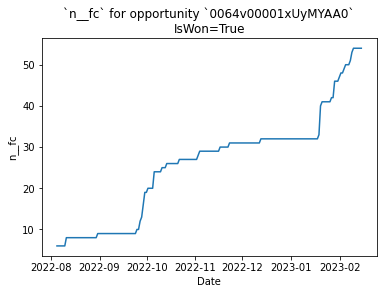

In [11]:
opp_id = '0064v00001xUyMYAA0'
opp_one = opp_df2[opp_df2.OpportunityId == opp_id]
metric = 'n__fc'

plt.plot(opp_one['CreatedDate'], opp_one[metric])
plt.xlabel('Date')
plt.ylabel(metric)
plt.title(f"`{metric}` for opportunity `{opp_id}`\nIsWon={opp_one.IsWon.unique()[0]}")
plt.show()

**Figure 1.1.** Plot demonstrating the increase in incoming emails for one opportunity over its lifetime.

Before we proceed, let's also merge data on outgoing and indirect communications, using the same methods as above:

In [12]:
# read outgoing communications (aggregated) data
tc_df = pd.read_parquet('src/email_data_TC.parquet')
# read indirect communications (aggregated) data
fo_df = pd.read_parquet('src/email_data_FO.parquet')

tc_attached, opp_df2 = _attach(tc_df, opp_df2)
opp_df2 = _join(tc_attached, opp_df2, '__tc')  # add suffix (tc - to client) to show that these communications are outgoing
fo_attached, opp_df2 = _attach(fo_df, opp_df2)
opp_df2 = _join(fo_attached, opp_df2, '__fo')  # add suffix (fo - from outside) to show that these communications are indirect
opp_df2 = opp_df2.fillna(0)  # fill empty values with zeroes since there were no communications for those stages
opp_df2.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,last__fc,n__fc,mean_n_owner_included__fc,mean_duration_in__fc,mean_duration_out__fc,mean_n_recipients__fc,...,mean_duration_out__tc,mean_n_recipients__tc,mean_n_to__tc,last__fo,n__fo,mean_n_owner_included__fo,mean_duration_in__fo,mean_duration_out__fo,mean_n_recipients__fo,mean_n_to__fo
0,0061300001ADuHtAAL,2022-08-29,False,2021-02-21 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0061300001ADuHtAAL,2022-08-29,False,2021-02-22 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0061300001ADuHtAAL,2022-08-29,False,2021-02-23 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0061300001ADuHtAAL,2022-08-29,False,2021-02-24 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0061300001ADuHtAAL,2022-08-29,False,2021-02-25 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
opp_df2.iloc[0:1000].to_csv('dataset.csv', index=False)
fc_df.iloc[0:1000].to_csv('fc_df_slice.csv', index=False)

## Feature Engineering

Before we continue, let's define the target for our model. The target should describe whether a given opportunity closes in a given quarter. Therefore, it's not enough that `IsWon==True` but also that `FQ(opp_estimated_close_date)==FQ(CreatedDate)`, where `FQ()` describes a fiscal quarter of a given date. Let's construct this target below:

In [20]:
# find the first time opportunity is created
opp_df2['first_created_date'] = opp_df2.groupby('OpportunityId')['CreatedDate'].transform('min')

# find fiscal quarters for the datetime features
opp_df2.loc[:, 'CreatedDate__fq'] = pd.PeriodIndex(opp_df2['CreatedDate'], freq='Q-JUN')
opp_df2.loc[:, 'opp_estimated_close_date__fq'] = pd.PeriodIndex(opp_df2['opp_estimated_close_date'], freq='Q-JUN')

opp_df2[['opp_estimated_close_date', 'opp_estimated_close_date__fq', 'CreatedDate', 'CreatedDate__fq']]

,opp_estimated_close_date,opp_estimated_close_date__fq,CreatedDate,CreatedDate__fq
0,2022-08-29,2023Q1,2021-02-21 20:53:45,2021Q3
1,2022-08-29,2023Q1,2021-02-22 20:53:45,2021Q3
2,2022-08-29,2023Q1,2021-02-23 20:53:45,2021Q3
3,2022-08-29,2023Q1,2021-02-24 20:53:45,2021Q3
4,2022-08-29,2023Q1,2021-02-25 20:53:45,2021Q3
...,...,...,...,...
183112,2023-01-11,2023Q3,2023-01-06 20:53:45,2023Q3
183113,2023-01-11,2023Q3,2023-01-07 20:53:45,2023Q3
183114,2023-01-11,2023Q3,2023-01-08 20:53:45,2023Q3
183115,2023-01-11,2023Q3,2023-01-09 20:53:45,2023Q3


In [21]:
opp_df2['target'] = (opp_df2['IsWon']) & (opp_df2['opp_estimated_close_date__fq'] == opp_df2['CreatedDate__fq'])
opp_df2['target'].value_counts()

False    175687
True       7430
Name: target, dtype: int64

We see that it is much more common that the opportunities are not in the target than in it. This is likely to be coming from two factors. First, it is possible that only a minority of opportunities closes successfully at any point. This is easy to check:  

In [16]:
iswon = opp_df2.groupby("OpportunityId")['IsWon'].apply('first').value_counts()
print(f"Win Rate is {iswon[True]/sum(iswon)*100:.2f}%")

Win Rate is 20.37%


The second is the fact that the target equals to $1$ only if it was successfully closed in the quarter equal to `CreatedDate__fq`. This means that if an opportunity is won but it was created in a different fiscal quarter, it will still have some corresponding targets set to $0$. We should make a note of this target imbalance for building the model later on.

Now, let's plot multiple incoming emails trends for a subset of opportunities and analyze how we could split them into successful and unsuccessful.

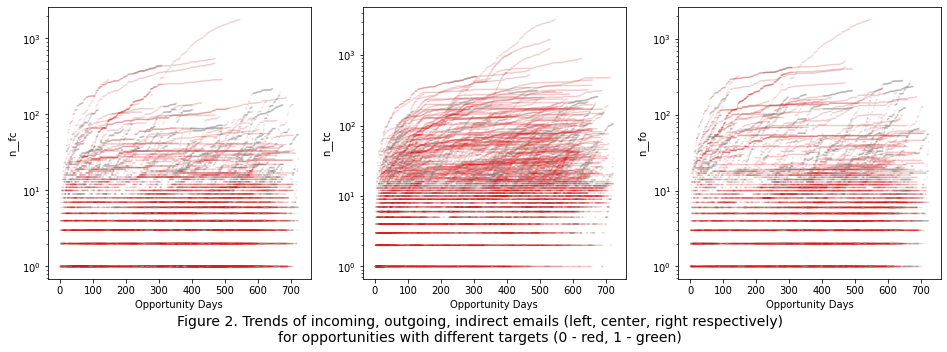

In [17]:
fig, axx = plt.subplots(1, 3, figsize=(16, 5))

for metric, ax in zip(['n__fc', 'n__tc', 'n__fo'], axx):
    ax.scatter((opp_df2['CreatedDate'] - opp_df2['CreatedDate'].min()).dt.days, opp_df2[metric], s=0.5, c=opp_df2.target, cmap='Set1', alpha=0.15*opp_df2.target + 0.04)
    ax.set_yscale('log')
    ax.set_xlabel("Opportunity Days")
    ax.set_ylabel(f"{metric}")
fig.text(0.5, -0.05, "Figure 2. Trends of incoming, outgoing, indirect emails (left, center, right respectively)\nfor opportunities with different targets (0 - red, 1 - green)", fontsize=14, ha='center')
plt.show()

Fig. 2 shows the trends of different kinds of emails for opportunities that are in and not in target. The issue is that different opportunities last differnet amounts of time, so it is difficult to see the trends well. Let's normalize the x-scale for opportunities length so that the scale shows the opportunity lifetime in percents not in days:

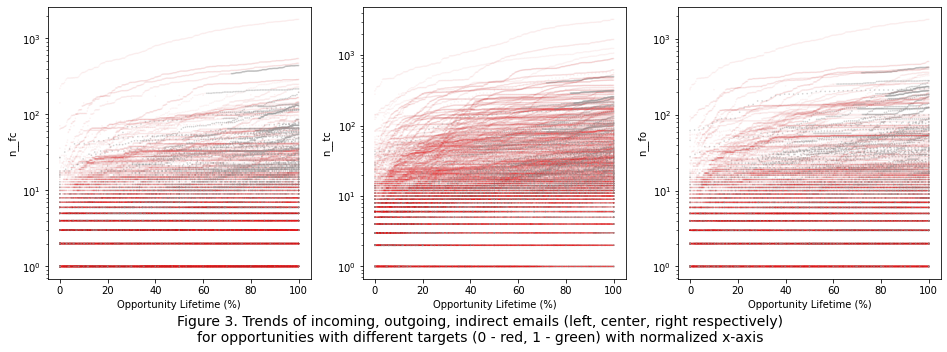

In [19]:
opp_groups = opp_df2.groupby('OpportunityId')
xscale = (opp_df2['CreatedDate'] - opp_groups['CreatedDate'].transform(min)).dt.days / (opp_groups['CreatedDate'].transform('max') - opp_groups['CreatedDate'].transform('min')).dt.days

fig, axx = plt.subplots(1, 3, figsize=(16, 5))
for metric, ax in zip(['n__fc', 'n__tc', 'n__fo'], axx):
    ax.scatter(xscale * 100, opp_df2[metric], s=0.5, c=opp_df2.target, cmap='Set1', alpha=0.3*opp_df2.target + 0.04)
    ax.set_yscale('log')
    ax.set_xlabel("Opportunity Lifetime (%)")
    ax.set_ylabel(f"{metric}")
fig.text(0.5, -0.05, "Figure 3. Trends of incoming, outgoing, indirect emails (left, center, right respectively)\nfor opportunities with different targets (0 - red, 1 - green) with normalized x-axis", fontsize=14, ha='center')
plt.show()

Now, Fig. 3 show the trends a bit more prominently as the endtime of the opportunity lifetime is aligned. The left panel shows that the target units tend to have a higher value of incoming emails. This is intuitive since this shows that the client is interested in conducting business. A similar trend can be noticed in the right panel (indirect communications). This can be explained through the fact that third-parties (e.g. SalesForce) might need to be involved to allow for smooth integration of the Revenue Grid software into the clients ecosystem. Finally, the middle panel shows that the outgoing communications might not be great predictors of opportunity success.

The plots above show that in-target opportunities tend to have somewhere between $20$ and $200$ emails by the time they close, while out-target opportunities cover a much higher range from $1$ to $500$ emails, for each category. Therefore, we should expect that our model wouldn't have a lot of problem telling lost opportunities that don't have a lot of emails (as this is the case exclusively for lost opportunities), but some data transformations are needed to separate other opportunities.

In addition to this, we can see that some opportunities' communications do not start at $0$ at the start of the opportunity. This describes the cases when the communication started before the opportunity was actually added to the database. It is debatable whether these communications should be included into our consideration. The non-zero starting point might provide valuable information that communication on the opportunity started much earlier.

One seemingly obvious solution is to just plot the graphs (and consider an opportunity as existing) from the date of the first communication. This will not, however, work, since this knowledge is obtained only retrospectively - before the opportunity is added to the database, no communication could be directly linked to it, making this solution unusable for predictive inference.

We will keep this information as is for now.

In [20]:
cond = opp_df2['CreatedDate'] == opp_df2['first_created_date']  # get only first unit for each opp
n_at_start = opp_df2[cond][['n__fc', 'n__tc', 'n__fo']].sum(axis=1)  # check existing communications as of date of opp creation
ratio = sum(n_at_start > 0) / len(n_at_start)  # find % of opps with existing communication prior to opp creation
print(f"{ratio*100:.2f}% of opportunities have at least 1 communication prior to the official start of that opportunity ")


63.15% of opportunities have at least 1 communication prior to the official start of that opportunity 


Rather than looking at the aggregate number of communications, it might be useful to analyze some more dynamic features. We can start by looking at the average number of (incoming/outgoing/indirect) emails per day. Looking at this data over opportunity lifetime can provide us with information over the dynamic rather than static trends.

In [21]:
opp_duration_days = (opp_df2['CreatedDate'] - opp_df2['first_created_date']).dt.days + 1
for metric in ['n__fc', 'n__tc', 'n__fo']:
    opp_df2[f'{metric}_rrate'] = opp_df2[metric] / opp_duration_days  # rrate stands for rolling rate
    print(opp_df2[f'{metric}_rrate'].describe())
    print()

count    183117.000000
mean          0.158603
std           1.034091
min           0.000000
25%           0.000000
50%           0.010417
75%           0.100000
max         220.000000
Name: n__fc_rrate, dtype: float64

count    183117.000000
mean          0.427433
std           1.969299
min           0.000000
25%           0.013274
50%           0.126531
75%           0.400000
max         311.000000
Name: n__tc_rrate, dtype: float64

count    183117.000000
mean          0.182935
std           1.238000
min           0.000000
25%           0.000000
50%           0.006885
75%           0.104683
max         224.000000
Name: n__fo_rrate, dtype: float64



For these features, the value of $1$ would mean that there is $1$ email per day for a specific opportunity. Note the mean and median values being below $0.5$ and $0.13$ respectively for all kinds of communication, meaning that even $1$ communication of a specific kind per day must be a high value. Finally, the high `max` values represent the cases when there was a lot of communication prior to the start of the opportunity, in which case it all counts toward the first day, heavily inflating the rate.

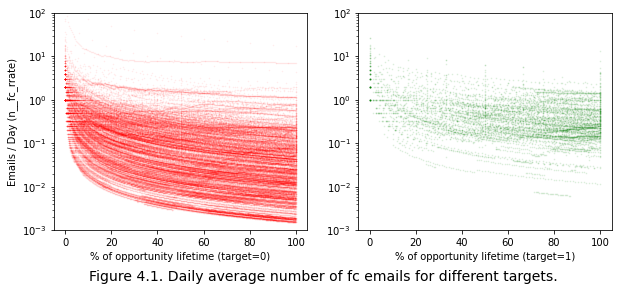

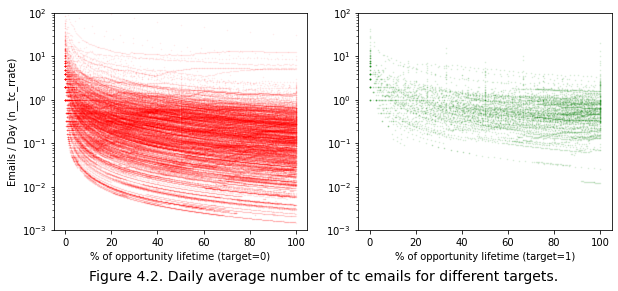

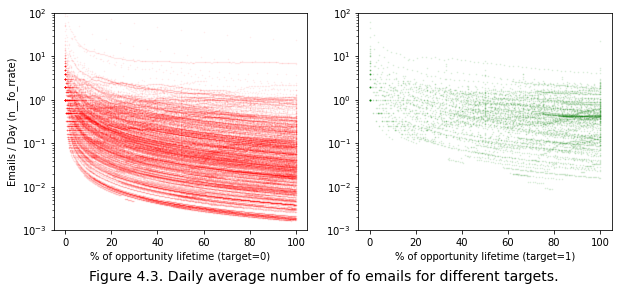

In [22]:

for i, metric in enumerate(['n__fc_rrate', 'n__tc_rrate', 'n__fo_rrate']):
    fig, axx = plt.subplots(1, 2, figsize=(10, 4))
    for target in (0, 1):
        color, alpha = ('r', 0.05) if target == 0 else ('g', 0.1)
        label = f"{target=}"
        cond = opp_df2['target'] == target
        axx[target].scatter(xscale[cond] * 100, opp_df2[metric][cond], s=0.5, color=color, alpha=alpha, cmap='Set1')
        axx[target].set_yscale('log')
        axx[target].set_ylim((10e-4, 10e1))
        axx[target].set_xlabel(f"% of opportunity lifetime ({target=})")
    axx[0].set_ylabel(f"Emails / Day ({metric})")
    fig.text(0.5, -0.05, f"Figure 4.{i+1}. Daily average number of {metric[3:5]} emails for different targets.", fontsize=14, ha='center')
    plt.show()

We display the plot above on the log scale to see the common trends instead of focusing on the outliers. We can see that the opportunities' `rrate` features (Fig. 4.1-4.3) all have downward trend throughout their lifetimes. Even so, the in-target units seem to have their `rrate` values decrease at a lower rate and even increase closer to the end of the opportunity lifetime. This is not evident in the out-target units (target=0). 

This difference in trends should be obvserable when we look at the secant line slopes for the lines shown above. We expect the prevalence of positive secant slopes in the second half of the won opportunities, while this should not be the case for the lost opportunities. In other words, for opportunities that are won, the average number of emails per day should be increasing as the opportunity develops over time, whereas it keeps declining for lost opportunities.

Let's calculate the 10-day changes in communications:

In [23]:
# we need to sort the dataset by dates to find secant lines
n_days = 10
opp_df2 = opp_df2.sort_values(['OpportunityId', 'CreatedDate'])

opp_groups = opp_df2.groupby('OpportunityId')
for label in ['n__fc_rrate', 'n__tc_rrate', 'nShrivastava__fo_rrate']:
    new_label = f'{label}_{n_days}d'
    opp_df2[new_label] = None
    for opp_id, group in opp_groups:
        rrate_ndays = group[label].shift(n_days)
        opp_df2.loc[group.index, new_label] = (group[label] - rrate_ndays)
        opp_df2.loc[group.index, new_label].iloc[:10] = None
    opp_df2[new_label] = opp_df2[new_label].astype(float)
    print(opp_df2.groupby('target')[new_label].mean())

target
False   -0.036052
True    -0.119375
Name: n__fc_rrate_10d, dtype: float64
target
False   -0.094867
True    -0.204365
Name: n__tc_rrate_10d, dtype: float64
target
False   -0.037266
True    -0.112598
Name: n__fo_rrate_10d, dtype: float64


All means are negative! Not quite what one would expect! This seems to happen due to the fact that a lot of opportunities start with some high number of communications (see Figg. 3, 4), resulting in a huge drop in the rate of change of of the number of communications. While this complicates the interpretation, it should not be a problem for a tree-based model.

/tmp/ipykernel_60325/1366381732.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axx[target].scatter(xscale.iloc[n_days:][cond] * 100, opp_df2.iloc[n_days:][cond][metric], s=0.5, color=color, alpha=alpha, cmap='Set1')


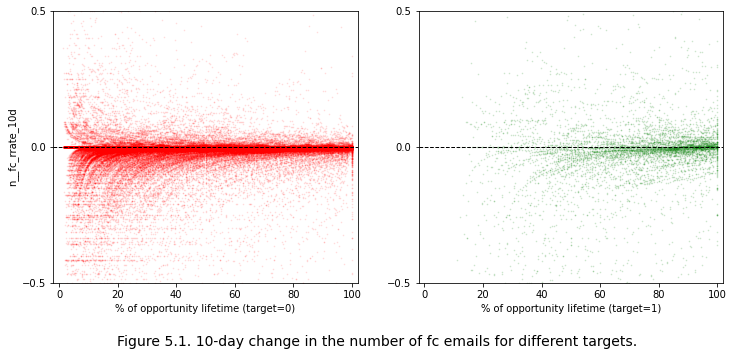

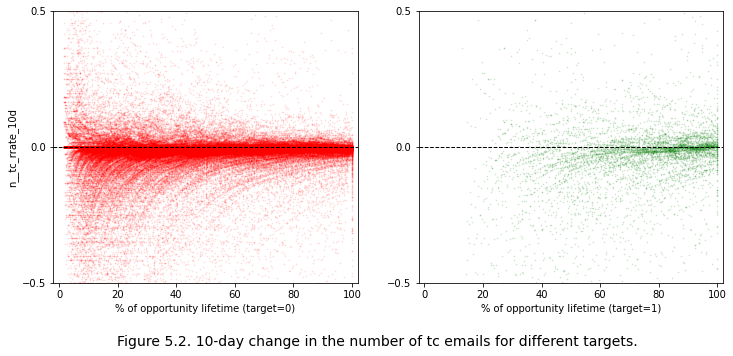

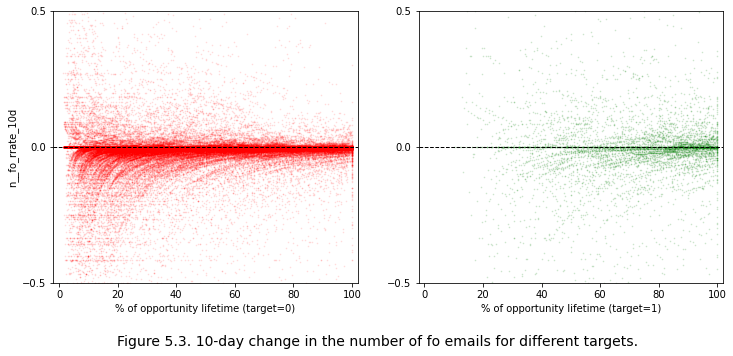

In [25]:
opp_groups = opp_df2.groupby('OpportunityId')
xscale = (opp_df2['CreatedDate'] - opp_groups['CreatedDate'].transform(min)).dt.days / (opp_groups['CreatedDate'].transform('max') - opp_groups['CreatedDate'].transform('min')).dt.days

for i, metric in enumerate([f'n__fc_rrate_{n_days}d', f'n__tc_rrate_{n_days}d', f'n__fo_rrate_{n_days}d']):
    fig, axx = plt.subplots(1, 2, figsize=(12, 5))
    for target in (0, 1):
        color, alpha = ('r', 0.1) if target == 0 else ('g', 0.15)
        label = f"{target=}"
        cond = opp_df2['target'] == target
        axx[target].scatter(xscale.iloc[n_days:][cond] * 100, opp_df2.iloc[n_days:][cond][metric], s=0.5, color=color, alpha=alpha, cmap='Set1')
        
        axx[target].set_xlabel(f"% of opportunity lifetime ({target=})")
        axx[target].hlines(y=0, xmin=-2, xmax=102, color='black', linestyle='--', linewidth=1)
        axx[target].set_ylim([-0.5, 0.5])
        axx[target].set_xlim([-2, 102])
        axx[target].set_yticks([-0.5, 0, 0.5])

    axx[0].set_ylabel(metric)
    fig.text(0.5, -0.05, f"Figure 5.{i+1}. 10-day change in the number of {metric[3:5]} emails for different targets.", fontsize=14, ha='center')
    plt.show()

Fig. 5.1-5.3 show that the changes take on both positive and negative values for in-target units while for out-target units, the rate is mostly declining (albeit close to $0$). The first 10 days of opportunity lifetime are not plotted as the value does not exist for that time period. Positive value indicate that in the last 10 days, the average daily number of incoming emails has increased. We can see that for the in-target units (right panel), the values are centered around $0$ or positive toward the end of the opportunity, while for the out-target panels (left) they are negative much more often.

## Model Training

Before we start training our model, we will split the data into a train and validation dataset. Since we are working with time series data, we put earlier data (fiscal quarters (FQs) 2021Q3 through 2022Q4) into the train subset, and the later data (FQs 2023Q1-2023Q2). Finally, we remove 2023Q3 from the dataset since it has not yet finished and changes might happen in it.

In [26]:
opp_df2 = opp_df2.sort_values('CreatedDate', ascending=True)

opp_df2_train, opp_df2_val = (
    opp_df2[opp_df2.CreatedDate__fq < '2023Q1'],
    opp_df2[(opp_df2.CreatedDate__fq >= '2023Q1') & (opp_df2.CreatedDate__fq < '2023Q3')]
)

The code cell below defines two important hyperparameter sets. First is `trial_config` that describes the LightGBM hyperparameters ranges. We will start with a simple search space that is not focused on decreasing overfit, for now. 

Second is the set of columns that are used in training. For now, they are `n__fc`, `n__tc`, `n__fo`, `n__fc_rrate`, `n__tc_rrate`, `n__fo_rrate`, but more are to be added.

In [43]:
trial_config = {
  'suggest_float':
    {
        #'reg_alpha': {'name': 'reg_alpha', 'low': 1e-3, 'high': 10.0, 'log': True},
        #'reg_lambda': {'name': 'reg_lambda', 'low': 1e-3, 'high': 10.0, 'log': True},
        'learning_rate': {'name': 'learning_rate', 'low': 0.001, 'high': 0.1, 'log': True},
        #'subsample': {'name': 'subsample', 'low': 0.2, 'high': 0.8},
        #'colsample_bytree': {'name': 'colsample_bytree', 'low': 0.2, 'high': 1},
        #'min_split_gain': {'name': 'min_split_gain', 'low': 0.01, 'high': 0.7},
        #'min_child_weight': {'name': 'min_child_weight', 'low': 0.0001, 'high': 0.4, 'log': True},
    },

  'suggest_int':
    {
        'n_estimators': {'name': 'n_estimators', 'low': 10, 'high': 500},
        'num_leaves': {'name': 'num_leaves', 'low': 7, 'high': 2047},
        #'subsample_freq': {'name': 'subsample_freq', 'low': 1, 'high': 100},
        'min_child_samples': {'name': 'min_child_samples', 'low': 10, 'high': 2700},
    }
    
}

train_columns = ['n__fc', 'n__tc', 'n__fo', 'n__fc_rrate', 'n__tc_rrate', 'n__fo_rrate']
print("'n__fc', 'n__tc', 'n__fo', 'n__fc_rrate', 'n__tc_rrate', 'n__fo_rrate'".replace("'", '`'))

`n__fc`, `n__tc`, `n__fo`, `n__fc_rrate`, `n__tc_rrate`, `n__fo_rrate`


The following code cell defines the structure of our training. First, we will use cross-validation in time to train models. This means that at each point of training, the we will validate the model against some unseen data. Fig. 6 (adapted from Shrivastava, 2020) shows an intuitive scheme of this process. The functionality is imlpemented in the `objective_timecv_everyday()` function. The `get_estimator()` function finds the best parameters for the next model given all models developed previously in the same experiment.

![](timecvgraph.png)

**Figure 6.** Visualization of using cross-validation in time.

Finally, the `optimize()` function runs the experiment for `n_trials` trials and returns the best-performing model.

In [44]:
def objective_timecv_everyday(data, trial: optuna.Trial) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    def custom_time_split(x, y):
        groups = x.groupby('CreatedDate__fq')
        train_idx, test_idx = [], []
        for _, group in groups:
            test_idx = group.index
            if train_idx:
                yield train_idx, test_idx
            train_idx.extend(group.index)

    X, y = data, data['IsWon']  # get predictors and outputs 
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    for train_idx, test_idx in tqdm(custom_time_split(X, y)):
        # split the dataset into test and train using the custom function above
        x_train, y_train = X.loc[train_idx], y.loc[train_idx]
        x_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        # use the previously fitted model if possible
        boost = model if model.__sklearn_is_fitted__() else None
        
        model.fit(x_train[train_columns], y_train, init_model=boost)
        
        # generate predictions for the unseen quarter and save it
        y_pred = model.predict_proba(x_test[train_columns])[:, 1]
        metric = log_loss(y_test, y_pred)
        avg_metric.append(metric)
    
    return np.mean(avg_metric)


def get_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    if params is None:
        params = {}
        trial_node = trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                params[name] = method(**kwargs)
                
    model = lightgbm.LGBMClassifier(
        random_state=SEED, 
        objective='binary',  # classification
        importance_type='gain', 
        class_weight='balanced',  # because of class imbalance
        **params)
    return model


def optimize(data, objective, n_trials):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    objective: function - the objective to be minimized
    n_trials: int - the number of model iterations 
    
    Returns
    ------------
    LightGBMClassifier - the fitted model object
    """

    # optimize the model on `n_trials`
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(lambda trial: objective(data, trial), n_trials=n_trials)

    # retrieve the best model and fit it
    model = get_estimator(trial=None, params=study.best_params)
    model.fit(data[train_columns], data['IsWon'])
    return model

The following code cell outputs the best-performing models as well as performance statistics on 20 trials.

In [45]:
model = optimize(opp_df2_train, objective_timecv_everyday, 20)

[I 2023-04-07 15:27:24,560] A new study created in memory with name: no-name-0968b368-fd1c-4157-9f36-11b0725d3351
3it [00:03,  1.10s/it]
[W 2023-04-07 15:27:27,897] Trial 0 failed with parameters: {'learning_rate': 0.02471373418487883, 'n_estimators': 150, 'num_leaves': 470, 'min_child_samples': 1493} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/viktor/Minerva/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_60325/3947331909.py", line 93, in <lambda>
    study.optimize(lambda trial: objective(data, trial), n_trials=n_trials)
  File "/tmp/ipykernel_60325/3947331909.py", line 35, in objective_timecv_everyday
    model.fit(x_train[train_columns], y_train, init_model=boost)
  File "/home/viktor/Minerva/venv/lib/python3.9/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_sc

KeyboardInterrupt: 

From the output above, we see that the best results were achieved by trial 15 (log-loss=$0.38$). The search space steps taken by optuna were somewhat effective but mostly resulted in higher log-loss values. This is likely due to the fact that optuna requires a high-number of trials to find local optima. 

The table below makes a prediction for previously unseen data that we separated before. Let's see how well the model is doing:

In [ ]:
X_val, y_val = opp_df2_val, opp_df2_val['IsWon']
y_pred_proba = model.predict_proba(X_val[train_columns])[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("Classification Report for Validation Data")
print(classification_report(y_val, y_pred))
log_loss(y_val, y_pred)

For comparison and potential overfit, below are the same results on the train (seen) data:

In [ ]:
X_val, y_val = opp_df2_train, opp_df2_train['IsWon']

y_pred_proba = model.predict_proba(X_val[train_columns])[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("Classification Report for Train Data")
print(classification_report(y_val, y_pred))
log_loss(y_val, y_pred)

Comparting the tables above, we can notice several things. First, the f1-scores for the `True` samples for training and validation sets are $0.67$ and $0.35$ respectively as both precision and recall are much higher in the `True` training sample as compared to the `True` validation sample. This is a sign of overfit - the true samples generalize poorly. Similar is the situation with the `False` samples, although there, the difference between f1-scores is only $0.07$, meaning that the generalization is more successful. 

Another sign of overfit is the big difference in the log-loss values for the training and validation samples - $2.19$ and $6.29$ respectively.

Some ways to decrease this overfit is to prune the trees, subsample the samples used for tree growing, and add regularizations to disincentivize extreme parametrization (Yıldırım, 2020). As I plan to keep creating dynamic features, the overfit is likely to increase due to a higher number of features. Therefore, overfit regulation will be my next prominent step in the development of this model.

Finally, the output below shows a relative importance of different predictors. We can see that `n__fc_rrate` has the highest importance. This is supported by Fig. 4.1 that shows that the in-target and out-target units can be separable in a lot of cases. The least important are the features about indirect emails (prefixed `n__fo`). This is also reasonable since such emails are very unlikely to come from any decision makers or significantly change decision making.

In [ ]:
feature_importance = dict(zip(model.feature_name_, model.feature_importances_))
feature_importance = {k: v / sum(feature_importance.values()) * 100 for k, v in
                      sorted(feature_importance.items(), key=lambda x: -x[1])}
feature_importance

### Next Steps Outline

1. Generate other time-dependent features.
2. Research time-series predicting using trees.
3. Balance the model to reduce overfit.

## References

1. Shrivastava, S. (2020, January 14). Cross Validation in Time Series. Cross Validation: | by Soumya Shrivastava. Medium. Retrieved April 5, 2023, from https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
1. Yıldırım, S. (2020, October 1). Hyperparameter Tuning to Reduce Overfitting — LightGBM. Towards Data Science. Retrieved April 2, 2023, from https://towardsdatascience.com/hyperparameter-tuning-to-reduce-overfitting-lightgbm-5eb81a0b464e